In [1]:
import numpy as np
import pandas as pd

Загрузим данные

In [2]:
json_file=open('test_task.json',encoding='utf-8')
data = json_file.read()
data

'\ufeff[["Баклажаны с орехами упак", "Баклажаны с творожной начинкой от бренд-шефа АВ"], ["Блинчики с курицей упак (4 шт)", "Блинчики с мясом, Уже Готово , 140 г"], ["Блинчики с мясом упак (4 шт)", "Блинчики с мясом, Уже Готово , 220 г, Россия"], ["Блины без начинки упак", "Блины Русские от бренд-шефа АВ, Россия"], ["Винегрет упак", "Салат FreshSecret Винегрет 600г", "Винегрет с ароматным подсолнечным маслом, Уже Готово , 350 г"], ["Голубцы мясные тушеные в томатно-сливочном соусе от бренд-шефа АВ", "Голубцы мясные упак", "Голубцы мясные упак"], ["Запеканка творожная President Дольче ванильная 5,5% 350г", "Запеканка творожная упак", "Запеканка творожная с изюмом, Уже Готово , 300 г"], ["Морковь по-корейски", "Морковь по-корейски упак", "Салат FreshSecret Морковь по-корейски, 250г", "Морковь по-корейски, Уже Готово , 250 г"], ["Оладьи из кабачков упак", "Оладьи из кабачков, Уже Готово , 250 г"], ["Плов с мясом баранины упак", "Плов узбекский от бренд-шефа АВ"], ["Салат Коул Слоу упак", 

Распарсим данные и представим в формате массива

In [3]:
data=data[4:len(data)-3]
data=data.split('"], ["')
for i,d in enumerate(data):
    data[i]=d.split('", "')
data[:5]

[['Баклажаны с орехами упак',
  'Баклажаны с творожной начинкой от бренд-шефа АВ'],
 ['Блинчики с курицей упак (4 шт)', 'Блинчики с мясом, Уже Готово , 140 г'],
 ['Блинчики с мясом упак (4 шт)',
  'Блинчики с мясом, Уже Готово , 220 г, Россия'],
 ['Блины без начинки упак', 'Блины Русские от бренд-шефа АВ, Россия'],
 ['Винегрет упак',
  'Салат FreshSecret Винегрет 600г',
  'Винегрет с ароматным подсолнечным маслом, Уже Готово , 350 г']]

Можно заметить, что исходная группировка содержит ошибки, но в большенстве случаев корректно объединяет разные названия одного и того же товара. Сгруппированным названиям поставим в соответствие номер товара (метку группы).     

In [4]:
data_f=[]
for i,d in enumerate(data): 
    for t in d: data_f.append([t,i])
data_f=pd.DataFrame(data_f,columns=['product','target'])
data_f[:5]

,product,target
0,Баклажаны с орехами упак,0
1,Баклажаны с творожной начинкой от бренд-шефа АВ,0
2,Блинчики с курицей упак (4 шт),1
3,"Блинчики с мясом, Уже Готово , 140 г",1
4,Блинчики с мясом упак (4 шт),2


In [5]:
print('Количество объектов:',data_f.shape[0],'\nКоличество групп:',len(set(data_f['target'])))

Количество объектов: 3580 
Количество групп: 1223


Итак, стоит задача кластерезации. Полученное выше соответствие будем использовать для вычисления внешних метрик качества кластеризации.

Предобработка текста

In [6]:
import re

In [7]:
def metric_convert(number,metric): # переведем метрики количества к одним еденицам
    if metric in ['г','гр','g','грам','грамм']: return [float(number)/1000,'кг']
    elif metric in ['мг','mg', 'млг']: return [float(number)/1000000,'кг']
    elif metric in ['кг','kg']: return [float(number),'кг']
    elif metric in ['мл','ml']: return [float(number)/1000,'л']
    elif metric in ['л','l']: return [float(number),'л']
    elif metric in ['шт','штук']: return [float(number),'шт']
    else: return [float(number),metric]

In [8]:
def amount_parse(s): # парсинг метрик количества
    pattern = r"([0-9]*[.,]?[0-9]+) *(кг|kg|г|гр|грамм|грам|g|мг|млг|mg|л|лит|литр|l|мл|ml|шт|штук)"
    amount_re = re.compile(pattern)
    amount=amount_re.findall(s)
    if len(amount)==0: return [np.nan,np.nan] 
    amount=list(amount_re.findall(s).pop())
    if not re.search('^[.,]',amount[0]): amount[0]=float(amount[0].replace(',','.'))
    else: amount[0]=re.sub('[.,]','',amount[0])  
    return metric_convert(*amount)

In [9]:
def amount_del(s): # удаление метрик количества из исходной строки
    pattern = r"([0-9]*[.,]?[0-9]+) *(кг|kg|г|гр|грамм|грам|g|мг|млг|mg|л|лит|литр|l|мл|ml|шт|штук)"
    amount_re = re.compile(pattern)
    amount=amount_re.findall(s)
    if len(amount)==0: return s
    amount=list(amount_re.findall(s).pop())
    pattern = r"{} *{}".format(*amount)
    return re.sub(pattern,'',s)  

In [10]:
def num_parse(s): # парсинг оставшихся числовых данных
    pattern = r"([0-9]*[.,]*[0-9]+[%]?)"
    number_re = re.compile(pattern)
    num_arr=number_re.findall(s)
    return [x.replace(',','.') for x in num_arr]

In [11]:
def num_del(s): # удаление оставшихся числовых данных из исходной строки
    pattern = r"([0-9]*[.,]*[0-9]+[%]?)"
    return re.sub(pattern,'',s)

In [12]:
def concat_arr(arr): # соединение элементов массива в одну строку 
    s=''
    for el in arr: s+=el+' '
    return s[:len(s)-1]

In [13]:
data_f['product_sparse']=list(map(lambda x: x.lower(),data_f['product'])) #заменяем заглавные буквы на прописные
data_f['product_sparse']=list(map(lambda x: re.sub('[\(\)\'\"\\\[\]]','',x), data_f['product_sparse'])) #удаляем скобки, левый слеш, кавычки
data_f['product_sparse']=list(map(lambda x: re.sub('[\/]',' ',x), data_f['product_sparse'])) #заменяем правый слеш на пробел
data_f=pd.concat([data_f,pd.DataFrame(list(map(lambda x: amount_parse(x),data_f['product_sparse'])),columns=['value','metric'])],axis=1)
data_f['product_sparse']=list(map(lambda x: amount_del(x),data_f['product_sparse'])) #удаляем количественную характеристику товара из исходной строки
data_f['number']=list(map(lambda x: num_parse(x),data_f['product_sparse'])) #извлекаем оставшиеся числовые характеристики товара
data_f['product_sparse']=list(map(lambda x: num_del(x),data_f['product_sparse'])) #удаляем оставшиеся числовые характеристики товара из исходной строки
data_f['product_sparse']=list(map(lambda x: re.sub('[\,\.\-\+\*\!\?\&]',' ',x), data_f['product_sparse'])) #заменяем знаки припинания и спец символы пробелом
data_f['product_sparse']=list(map(lambda x: re.sub('( [a-zа-я] )',' ',x), data_f['product_sparse'])) #удаляем одиночные буквы
data_f['product_sparse']=list(map(lambda x: re.sub('( для | от | до | со | по | из | на | за | над | под | при | про | без )',' ',x), data_f['product_sparse'])) #удаляем предлоги
data_f['product_sparse']=list(map(lambda x: re.sub('\s+',' ',x), data_f['product_sparse'])) #убираем лишние пробелы
data_f['product_sparse']=list(map(lambda x:concat_arr(x[0])+' '+x[1],zip(data_f['number'],data_f['product_sparse']))) #соединяем обработанные текстовые и числовые массивы
data_f=data_f.drop(['number'],axis=1) #удаляем ненужный столбец

In [14]:
data_f[:20]

,product,target,product_sparse,value,metric
0,Баклажаны с орехами упак,0,баклажаны орехами упак,NaN,NaN
1,Баклажаны с творожной начинкой от бренд-шефа АВ,0,баклажаны творожной начинкой бренд шефа ав,NaN,NaN
2,Блинчики с курицей упак (4 шт),1,блинчики курицей упак,4.00,шт
3,"Блинчики с мясом, Уже Готово , 140 г",1,блинчики мясом уже готово,0.14,кг
4,Блинчики с мясом упак (4 шт),2,блинчики мясом упак,4.00,шт
5,"Блинчики с мясом, Уже Готово , 220 г, Россия",2,блинчики мясом уже готово россия,0.22,кг
6,Блины без начинки упак,3,блины начинки упак,NaN,NaN
7,"Блины Русские от бренд-шефа АВ, Россия",3,блины русские бренд шефа ав россия,NaN,NaN
8,Винегрет упак,4,винегрет упак,NaN,NaN
9,Салат FreshSecret Винегрет 600г,4,салат freshsecret винегрет,0.60,кг


Итак, данные почти готовы. Стемминг использовать не будем, т.к. в данной задаче в большинстве случаев одинаковые слова находятся в одинаковой форме. Далее можно пойти 2мя путями: 1ый - value и metric присоеденить к product_sparse и затем использовать общий мешок слов, или 2ой путь - value и metric использовать как отдельные признаки, но для этого нужно грамотно заполнить пропуски. Описанные подходы будут давать разные результаты.

Пойдем по 1ому пути, т.к. он проще.

In [15]:
data_f['product_sparse_common_bow']=list(map(lambda x: ('' if x[0]==True else str(x[2]))+' '
                                             +('' if x[1]==True else str(x[3]))+' '+ x[4],
                                             zip(data_f['value'].isnull(), data_f['metric'].isnull(), 
                                                 data_f['value'], data_f['metric'], data_f['product_sparse'])))

In [16]:
data_f[:20]

,product,target,product_sparse,value,metric,product_sparse_common_bow
0,Баклажаны с орехами упак,0,баклажаны орехами упак,NaN,NaN,баклажаны орехами упак
1,Баклажаны с творожной начинкой от бренд-шефа АВ,0,баклажаны творожной начинкой бренд шефа ав,NaN,NaN,баклажаны творожной начинкой бренд шефа ав
2,Блинчики с курицей упак (4 шт),1,блинчики курицей упак,4.00,шт,4.0 шт блинчики курицей упак
3,"Блинчики с мясом, Уже Готово , 140 г",1,блинчики мясом уже готово,0.14,кг,0.14 кг блинчики мясом уже готово
4,Блинчики с мясом упак (4 шт),2,блинчики мясом упак,4.00,шт,4.0 шт блинчики мясом упак
5,"Блинчики с мясом, Уже Готово , 220 г, Россия",2,блинчики мясом уже готово россия,0.22,кг,0.22 кг блинчики мясом уже готово россия
6,Блины без начинки упак,3,блины начинки упак,NaN,NaN,блины начинки упак
7,"Блины Русские от бренд-шефа АВ, Россия",3,блины русские бренд шефа ав россия,NaN,NaN,блины русские бренд шефа ав россия
8,Винегрет упак,4,винегрет упак,NaN,NaN,винегрет упак
9,Салат FreshSecret Винегрет 600г,4,салат freshsecret винегрет,0.60,кг,0.6 кг салат freshsecret винегрет


Данные готовы. Сформируем матрицу признаков используя данные столбца product_sparse_common_bow.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [61]:
f_matrix= TfidfVectorizer().fit_transform(data_f['product_sparse_common_bow'])
f_matrix=f_matrix.toarray()
f_matrix.shape

(3580, 2973)

Уберем признаки, которые имеют маленькое суммарное значение, т.е. признаки, имеющие маленький вес.

In [62]:
f_df=pd.DataFrame(f_matrix)
f_matrix=np.array(f_df[f_df.columns[f_df.apply(sum)>0.5]])
f_matrix.shape

(3580, 2442)

Далее будем кластеризовать данные, используя полученные признаки.

Т.к. кластеров много, и они маленькие, будем использовать аггломеративную кластеризацию. Для оценки качества кластеризации будем использовать V-меру.

In [20]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster.hierarchical import AgglomerativeClustering
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


У нас уже есть представление о количестве кластеров. Попробуем прикинуть количество кластеров "по-честному". Для этого построим дендрограмму.

Wall time: 38.1 s


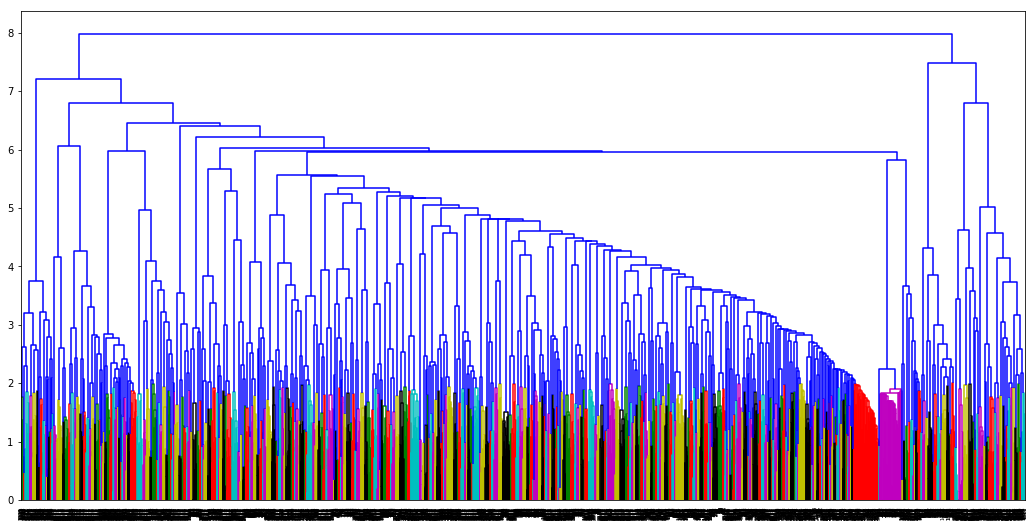

In [67]:
%%time
X = f_matrix
distance_mat = pdist(X,'euclidean') # посчитаем верхний треугольник матрицы попарных расстояний
Z = hierarchy.linkage(distance_mat, 'ward') # реализация агломеративного алгоритма с расстоянием Варда между кластерами
plt.figure(figsize=(18, 9))
dn = hierarchy.dendrogram(Z, color_threshold=2)

Ещё посмотрим график увеличения расстояний между кластерами в зависимости от количества итераций слияния.

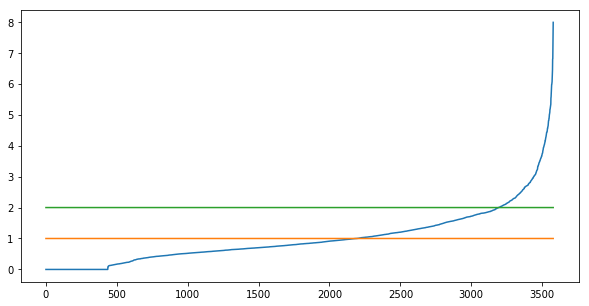

In [68]:
plt.figure(figsize=(10, 5))
plt.plot(range(Z.shape[0]),Z[:,2])
plt.plot(range(Z.shape[0]),np.full(Z.shape[0],1));
plt.plot(range(Z.shape[0]),np.full(Z.shape[0],2));

Из графика видно, что резкий рост начинается примерно с 3200-ой итерации (зеленая линия), что соответсвует примерно 300 кластерам. У нас же дано 1200 кластеров, что соответствует оранжевой линии.

Далее будем использовать количество кластеров, равное данному числу 1223.

In [63]:
model = AgglomerativeClustering(n_clusters=1223, affinity='euclidean', linkage='ward')
%time clusters = model.fit_predict(f_matrix)
data_f['cluster']=clusters

Wall time: 30.6 s


Посмотрим на результат кластеризации в таблице

In [64]:
data_f[['product','target','product_sparse_common_bow','cluster']].sort_values(['cluster'])[:20]

,product,target,product_sparse_common_bow,cluster
78,"Туалетная бумага Zewa Детская, влажная, 42 шт",30,42.0 шт туалетная бумага zewa детская влажная,0
80,"Туалетная бумага Zewa влажная, 42 шт",31,42.0 шт туалетная бумага zewa влажная,0
81,Бумага Zewa влажная Миндальное молочко 1шт Англия,32,1.0 шт бумага zewa влажная миндальное молочко...,0
82,"Туалетная бумага Zewa Миндальное молочко, влаж...",32,42.0 шт туалетная бумага zewa миндальное моло...,0
84,"Туалетная бумага Zewa Ромашка, влажная, 42 шт",33,42.0 шт туалетная бумага zewa ромашка влажная,0
2479,Пиво светлое Paulaner Hefe-Weisbier нефильтров...,856,0.5 л 5.5% пиво светлое paulaner hefe weisbier...,1
2441,Пиво Franziskaner Hefe-Weissbier светлое нефил...,840,0.5 л пиво franziskaner hefe weissbier светло...,1
2440,Пиво светлое Franziskaner Hefe-Weissbier нефил...,840,0.5 л 5% пиво светлое franziskaner hefe weissb...,1
2439,"Пиво FRANZISKANER Weissbier светлое, 0,5л",840,0.5 л пиво franziskaner weissbier светлое,1
2478,Пиво Paulaner Hefe-Weissbier светлое нефильтр....,856,0.5 л пиво paulaner hefe weissbier светлое не...,1


In [65]:
data_f[['product','target','product_sparse_common_bow','cluster']].sort_values(['target'])[:20]

,product,target,product_sparse_common_bow,cluster
0,Баклажаны с орехами упак,0,баклажаны орехами упак,171
1,Баклажаны с творожной начинкой от бренд-шефа АВ,0,баклажаны творожной начинкой бренд шефа ав,222
2,Блинчики с курицей упак (4 шт),1,4.0 шт блинчики курицей упак,947
3,"Блинчики с мясом, Уже Готово , 140 г",1,0.14 кг блинчики мясом уже готово,906
4,Блинчики с мясом упак (4 шт),2,4.0 шт блинчики мясом упак,947
5,"Блинчики с мясом, Уже Готово , 220 г, Россия",2,0.22 кг блинчики мясом уже готово россия,906
6,Блины без начинки упак,3,блины начинки упак,980
7,"Блины Русские от бренд-шефа АВ, Россия",3,блины русские бренд шефа ав россия,222
8,Винегрет упак,4,винегрет упак,389
9,Салат FreshSecret Винегрет 600г,4,0.6 кг салат freshsecret винегрет,389


Видно, что есть различия, но в целом кластеризация неплохо справляется со своей задачей. Что подтверждает и выбранная метрика v-мера.

In [66]:
metrics.v_measure_score(data_f['target'], data_f['cluster'])

0.9361960436451758

Для улучшения качества алгоритма, можно ещё попробовать использование метрики количества, как отдельного признака, различные конфигурации токенизации с использованием биграмм и триграмм, алгоритмы снижения размерности.